# Comparisons to Putative Event Boundaries- Jaccard Analysis of Segmentation Data
### Started August 14, 2020

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
import random
from sklearn.metrics import jaccard_score
%autosave 5

Autosaving every 5 seconds


### i. Import data

In [76]:
filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/parsing_log_file/pickle/data_dict_pilots_b1_b2_b3_b4.p'
data_dict = pickle.load( open( filename, "rb" ) )

### ii. import story files

In [77]:
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/fMRI experiment/1:8:2020_edited_stories'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

### iii. Exclusions
#### a. exclude participants who only pressed '1' or '9'

In [78]:
keys_to_del = []
for key in data_dict:
    kp = data_dict[key]['story_presses']
    check_kp = len(set(kp))
    if check_kp == 1:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    del data_dict[keys_to_del[i]]

/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot2/8/PARTICIPANT_1_online_exp_2020-05-11_12h52.50.131
5cf0a300b094d700183e4d54
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/145_1_online_exp_2020-06-10_15h14.14.911
5ec18c4c2f44695b38204649
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/171_1_online_exp_2020-06-10_21h32.27.534
5de12fbfe4f42a1842172d7a
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/418_1_online_exp_2020-07-16_09h12.22.806
5eb5dafddac6754c4ee9d0d7


#### b. Exclude participants who don't answer short answers

In [79]:
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/73_1_online_exp_2020-06-10_14h37.05.252']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/199_1_online_exp_2020-06-24_20h41.05.680']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/345_1_online_exp_2020-07-16_09h07.09.087']

#### d. Pickle data_dict in order to get group counts

In [80]:
pickle.dump( data_dict, open( 'check', "wb" ) )

# I. Organizing Putative Event Boundaries

In [81]:
#mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = int(dfs_stories[s]['story'].iloc[0])
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries[this_story] = keys2[:, np.newaxis]
    story_boundaries[this_story] = np.concatenate((story_boundaries[this_story], keys3[:, np.newaxis]), axis = 1)
    
#mark the changes or boundaries from one event to another with a '1' and delete first two columns
for key in story_boundaries:
    location = story_boundaries[key][:,0]
    social = story_boundaries[key][:,1]
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            location[i] = 7
    for i in range(0, len(location)):  
        if location[i] != 7:
            location[i] = 0
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            social[i] = 7
    for i in range(0, len(social)):
        if social[i] != 7:
            social[i] = 0
    location[0] = 7
    social[0] = 7
    location2 = location > 1
    social2 = social > 1
    location2 = location2.astype(int)
    social2 = social2.astype(int)
    story_boundaries[key] = np.concatenate((story_boundaries[key], location2[:, np.newaxis]), axis = 1) 
    story_boundaries[key] = np.concatenate((story_boundaries[key], social2[:, np.newaxis]), axis = 1)
    story_boundaries[key] = np.delete(story_boundaries[key] ,np.s_[0:2],axis=1)

# II. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [82]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

### i. Finding the number of participants in each category for each story
#### -output sums[story] = [total # of participants, no prime, loc primed, soc primed]

In [83]:
sums = {}

for key in all_keys_r:
    this_sum = []
    x, y = all_keys_r[key].shape
    this_sum.append(y)
    if key in none_keys_r:
        x, y = none_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in loc_keys_r:
        x, y = loc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in soc_keys_r:
        x, y = soc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    sums[key] = this_sum

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [84]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

# III. Jaccard Analysis
## A. Compare priming types of each story to putative event boundaries

In [85]:
jaccard_vals = {}

list_keys = [none_keys, loc_keys, soc_keys]

for key in all_keys:
    # Making array stored in jaccard_vals
    this_array = np.zeros ((2,3))
    # Iterating through all conditions
    for i in range(len(list_keys)):
        # Iterating through location and social putative boundaries
        for j in range(0,2):
            # Finding the number of participants in this condition
            n = list_keys[i][key].shape[1]
            # Initiating list to add jaccard values to
            these_vals = []
            for k in range(0,n):
                subj_k = list_keys[i][key].T[k]
                put_b = story_boundaries[key].T[j]
                this_ji = jaccard_score(subj_k, put_b)
                these_vals.append(this_ji)
            # Averaging Jaccard Indices
            avg_val = sum(these_vals) / len(these_vals)
            # Putting average in this_array
            this_array[j, i] = avg_val
    # Putting this_array in jaccard_vals
    jaccard_vals[key] = this_array  

## B. Plotting

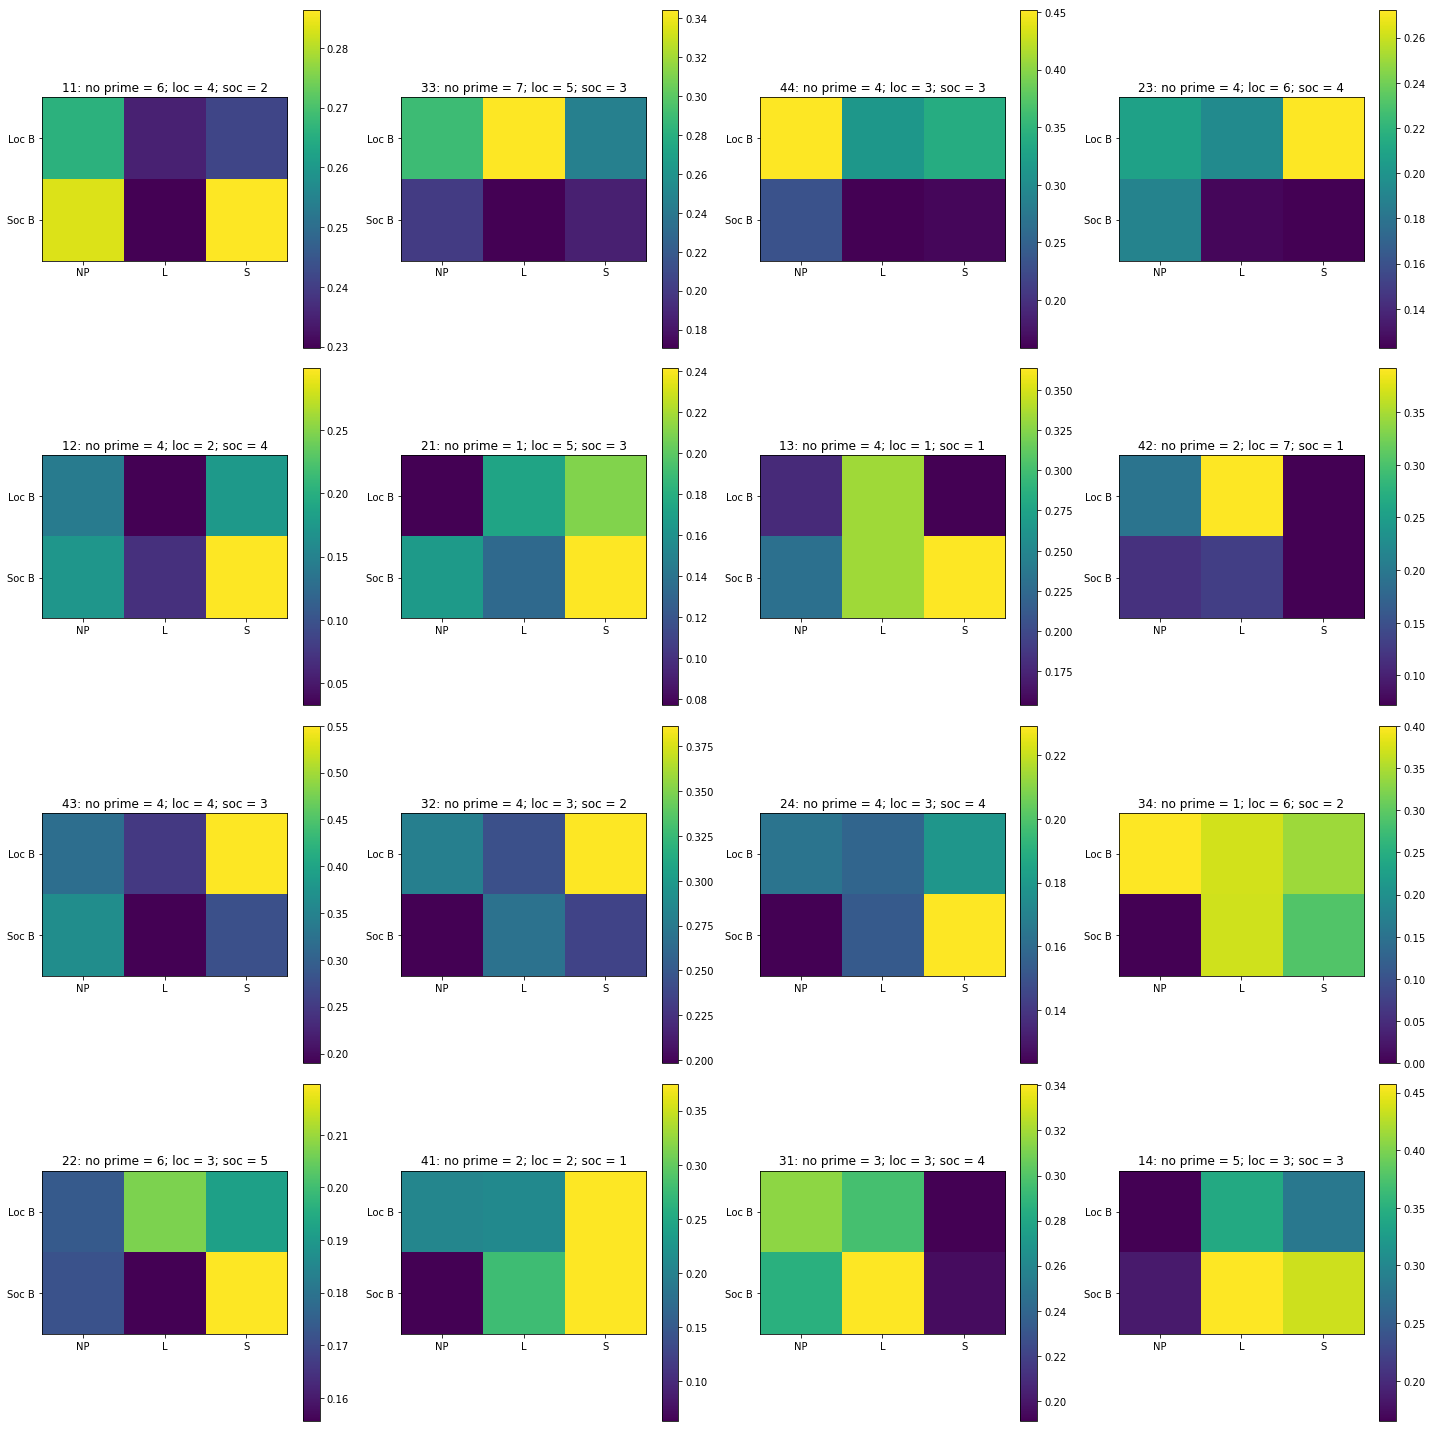

In [86]:
figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

i = 0
j = 0
for key in jaccard_vals:
    # Make the plot
    im = axes[j, i].imshow(jaccard_vals[key])
    
    #colorbar
    im.set_clim()
    figure.colorbar(im, ax=axes[j, i])
    
    #set title
    none_n = sums[key][1]
    loc_n = sums[key][2]
    soc_n = sums[key][3]
    axes[j, i].set_title(str(key) + ': no prime = ' + str(none_n) + '; loc = ' + str(loc_n) + '; soc = ' + str(soc_n))
    
    # X ticks
    x_label_list = ['NP', 'L', 'S']
    axes[j, i].set_xticks([0,1,2])
    axes[j, i].set_xticklabels(x_label_list)
    
    # Y ticks
    y_label_list = ['Loc B', 'Soc B']
    axes[j, i].set_yticks([0,1])
    axes[j, i].set_yticklabels(y_label_list)
     
    #changing i, j for next graph placement
    if i == 3:
        i = 0
        j += 1
    else:
        i += 1
    figure.tight_layout()

## C. Average Jaccard Values across all story avgs
### - this is the average of the 16 story values, not the data points that make those up. 

In [87]:
count = 0

for key in jaccard_vals:
    if count == 0:
        all_j_vals = jaccard_vals[key]
        count =+ 1
    else:
        all_j_vals = np.dstack((all_j_vals, jaccard_vals[key]))

# NanMean
avg_all_j_vals = np.nanmean(all_j_vals, axis = 2)

## D. Plot

[Text(0, 0, 'Loc B'), Text(0, 0, 'Soc B')]

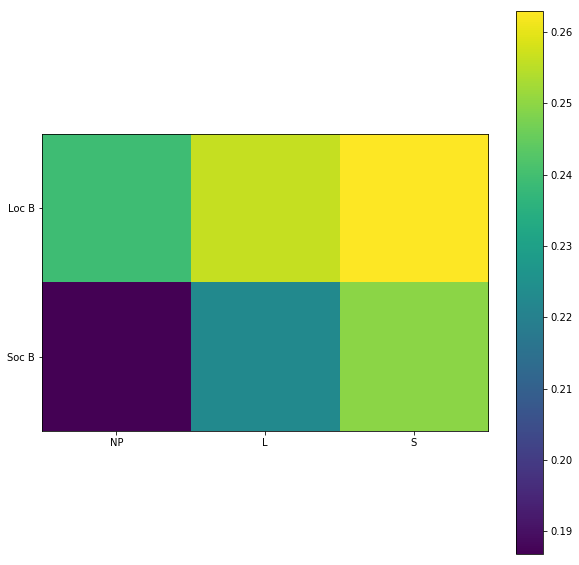

In [88]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_all_j_vals)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['Loc B', 'Soc B']
ax.set_yticks([0,1])
ax.set_yticklabels(y_label_list)

## E. Average Jaccard Values calculated from all the data points within the story avgs

In [89]:
jaccard_vals = {}

list_keys = [none_keys, loc_keys, soc_keys]
n_l = []
l_l = []
s_l = []
n_s = []
l_s = []
s_s = []

list_vals = [[n_l, l_l, s_l], [n_s, l_s, s_s]]

for key in all_keys:
    # Making array stored in jaccard_vals
    this_array = np.zeros ((2,3))
    # Iterating through all conditions
    for i in range(len(list_keys)):
        # Iterating through location and social putative boundaries
        for j in range(0,2):
            # Finding the number of participants in this condition
            n = list_keys[i][key].shape[1]
            # Initiating list to add jaccard values to
            these_vals = []
            for k in range(0,n):
                subj_k = list_keys[i][key].T[k]
                put_b = story_boundaries[key].T[j]
                this_ji = jaccard_score(subj_k, put_b)
                these_vals.append(this_ji)
                list_vals[j][i].append(this_ji)

avg_points_actual = np.zeros((2, 3))
for i in range(0,2):
    for j in range(0,3):
        this_avg = sum(list_vals[i][j])/len(list_vals[i][j])
        avg_points_actual[i,j] = this_avg

In [90]:
print(s_s)

[0.2727272727272727, 0.3, 0.058823529411764705, 0.25, 0.25, 0.1, 0.3, 0.09090909090909091, 0.125, 0.0, 0.16666666666666666, 0.2, 0.25, 0.36363636363636365, 0.3333333333333333, 0.25, 0.16666666666666666, 0.3076923076923077, 0.25, 0.36363636363636365, 0.07142857142857142, 0.16666666666666666, 0.16666666666666666, 0.5, 0.2727272727272727, 0.2, 0.16666666666666666, 0.25, 0.3333333333333333, 0.16666666666666666, 0.5, 0.08333333333333333, 0.16666666666666666, 0.21428571428571427, 0.25, 0.2857142857142857, 0.18181818181818182, 0.375, 0.041666666666666664, 0.375, 0.2, 0.16666666666666666, 0.5714285714285714, 0.4, 0.3333333333333333]


## F. Plotting

[Text(0, 0, 'Loc B'), Text(0, 0, 'Soc B')]

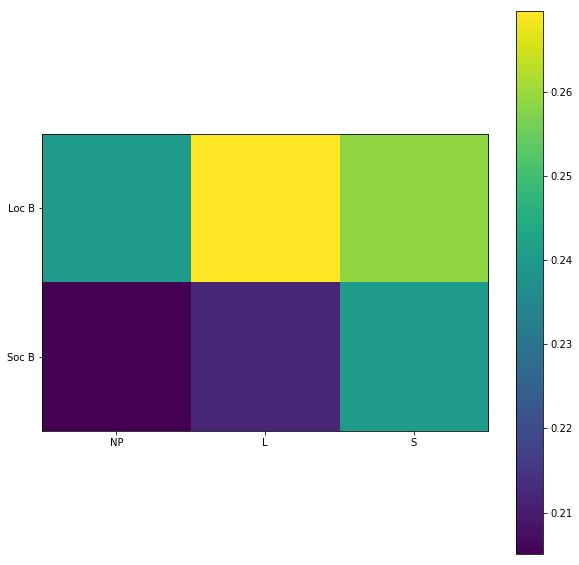

In [91]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_points_actual)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['Loc B', 'Soc B']
ax.set_yticks([0,1])
ax.set_yticklabels(y_label_list)

# IV. Correlation Analysis
## A. Calculate the correlations for each group with putative event boundaries

In [18]:
correl_vals = {}

list_keys = [none_keys, loc_keys, soc_keys]

n_l = []
l_l = []
s_l = []
n_s = []
l_s = []
s_s = []

list_vals = [[n_l, l_l, s_l], [n_s, l_s, s_s]]

for key in all_keys:
    # Making array stored in jaccard_vals
    this_array = np.zeros ((2,3))
    # Iterating through all conditions
    for i in range(len(list_keys)):
        # Iterating through location and social putative boundaries
        for j in range(0,2):
            # Finding the number of participants in this condition
            n = list_keys[i][key].shape[1]
            # Initiating list to add jaccard values to
            these_vals = []
            for k in range(0,n):
                subj_k = list_keys[i][key].T[k]
                put_b = story_boundaries[key].T[j]
                this_ji = np.corrcoef(subj_k, put_b)[0,1]
                these_vals.append(this_ji)
                list_vals[j][i].append(this_ji)
            # Averaging Jaccard Indices
            avg_val = sum(these_vals) / len(these_vals)
            # Putting average in this_array
            this_array[j, i] = avg_val
    # Putting this_array in jaccard_vals
    correl_vals[key] = this_array  

## B. Plotting

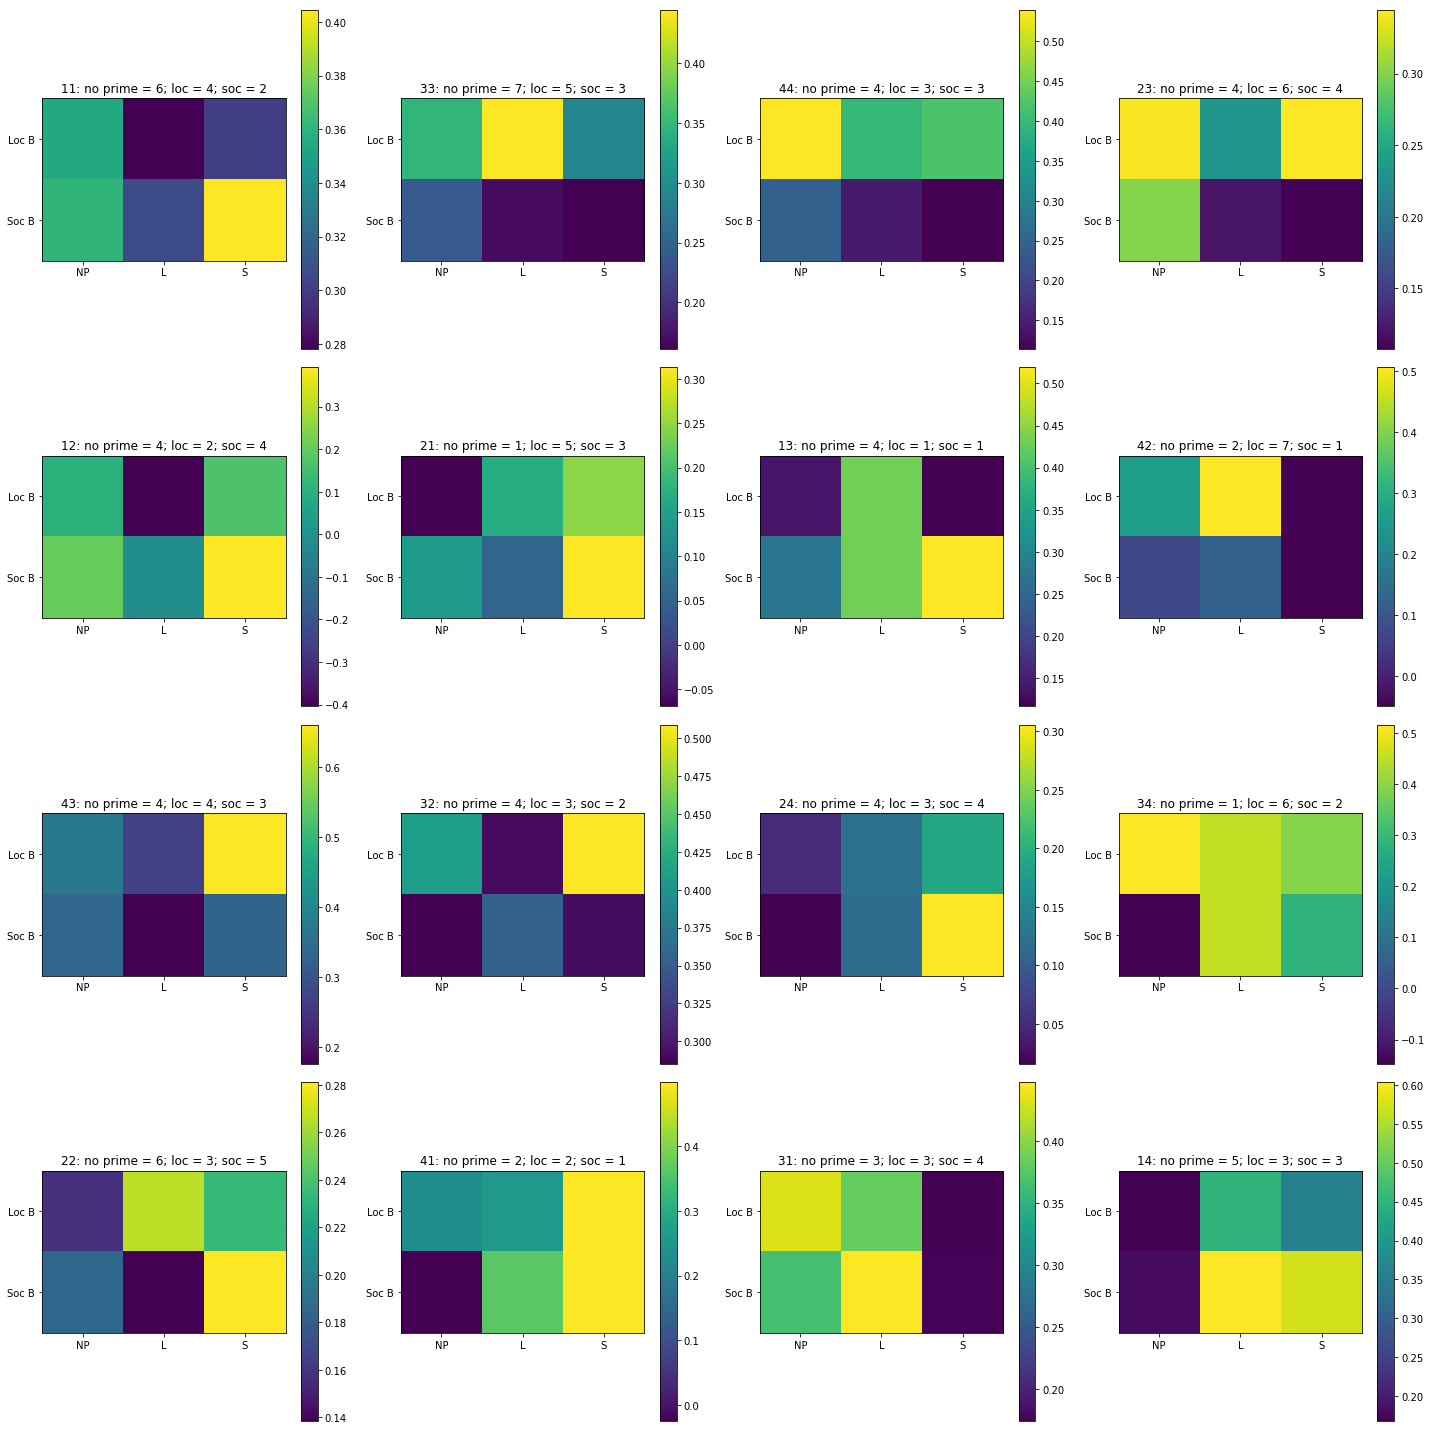

In [19]:
figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

i = 0
j = 0
for key in correl_vals:
    # Make the plot
    im = axes[j, i].imshow(correl_vals[key])
    
    #colorbar
    im.set_clim()
    figure.colorbar(im, ax=axes[j, i])
    
    #set title
    none_n = sums[key][1]
    loc_n = sums[key][2]
    soc_n = sums[key][3]
    axes[j, i].set_title(str(key) + ': no prime = ' + str(none_n) + '; loc = ' + str(loc_n) + '; soc = ' + str(soc_n))
    
    # X ticks
    x_label_list = ['NP', 'L', 'S']
    axes[j, i].set_xticks([0,1,2])
    axes[j, i].set_xticklabels(x_label_list)
    
    # Y ticks
    y_label_list = ['Loc B', 'Soc B']
    axes[j, i].set_yticks([0,1])
    axes[j, i].set_yticklabels(y_label_list)
     
    #changing i, j for next graph placement
    if i == 3:
        i = 0
        j += 1
    else:
        i += 1
    figure.tight_layout()

## C. Calculate and plot 

[Text(0, 0, 'Loc B'), Text(0, 0, 'Soc B')]

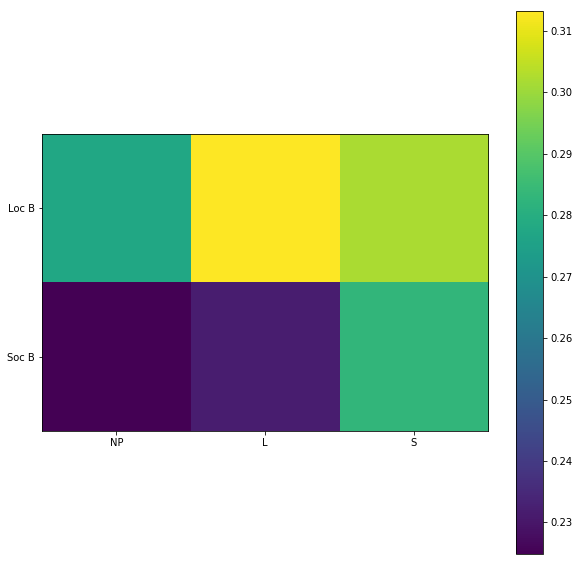

In [20]:
avg_points = np.zeros((2, 3))
for i in range(0,2):
    for j in range(0,3):
        this_avg = sum(list_vals[i][j])/len(list_vals[i][j])
        avg_points[i,j] = this_avg
        
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_points)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['Loc B', 'Soc B']
ax.set_yticks([0,1])
ax.set_yticklabels(y_label_list)

# V. Permutation Testing
## A. Randomly assign each participant to be in one of the three categories of loc_keys, soc_keys, none_keys, keeping the same number of participants in each group as the actual data (not a Montecarlo Randomization)
## - calculate the jaccard index for each keypress 
## - collect the 2 X 3 jaccard values for all iterations


In [97]:
N_perms = 1000
count = 0
better_primed = []
priming_interaction = []

for i in range(0, N_perms):
    ## Randomly assign the keypresses into categories preserving the number of participants in each category
    mix_loc = {}
    mix_soc = {}
    mix_none = {}
    for key in all_keys:
        # Permute an array the length of the number of columns
        this_order = np.random.permutation(all_keys[key].shape[1])
        # Shuffle the columns of the keys based on the permutation
        permuted_keys = all_keys[key][:, this_order]
        # Assign the participants to each group based on the number of actual participants are in that group
        mix_none[key] = permuted_keys[:, 0: sums[key][1]]
        mix_loc[key] = permuted_keys[:, sums[key][1]: (sums[key][1]+ sums[key][2])]
        mix_soc[key] = permuted_keys[:, (sums[key][1]+ sums[key][2]): sums[key][0]]
        
    ## Compare across all subj keypresses
    list_keys = [mix_none, mix_loc, mix_soc]
    n_l = []
    l_l = []
    s_l = []
    n_s = []
    l_s = []
    s_s = []

    list_vals = [[n_l, l_l, s_l], [n_s, l_s, s_s]]
    
    # Comparing each participant to location and social boundaries, and binning according to boundary compared to 
    # and what group the participant is from
    for key in all_keys:
        # Making array stored in jaccard_vals
        this_array = np.zeros ((2,3))
        # Iterating through all conditions
        for i in range(len(list_keys)):
            # Iterating through location and social putative boundaries
            for j in range(0,2):
                # Finding the number of participants in this condition
                n = list_keys[i][key].shape[1]
                for k in range(0,n):
                    subj_k = list_keys[i][key].T[k]
                    put_b = story_boundaries[key].T[j]
                    this_ji = jaccard_score(subj_k, put_b)
                    list_vals[j][i].append(this_ji)
    
    # Average across all the lists and fill in a 2X3 matrix with avg jaccard values
    avg_points = np.zeros((2, 3))
    for i in range(0,2):
        for j in range(0,3):
            this_avg = sum(list_vals[i][j])/len(list_vals[i][j])
            avg_points[i,j] = this_avg
    
    # Concatenate the 2 X 3 matrices of different permutations
    if count == 0:
        all_avg_points = avg_points
        count += 1
    else:
        all_avg_points = np.dstack((all_avg_points, avg_points))
        
    # Calculate and concatenate the statistics
    ## Is there a better matching to boundaries when primed?
    ## 2 - 1 + 6 - 4
    better_primed.append(avg_points[0,1] - avg_points[0,0] + avg_points[1,2] - avg_points[1, 0])
    
    ## Among people who were primed is there an interaction between the priming?
    ## 2 - 3 + 6 - 5
    priming_interaction.append(avg_points[0,1] - avg_points[0,2] + avg_points[1,2] - avg_points[1, 1])

## B. Average the jaccard values along third dimension and plot

[[0.2526931  0.2685676  0.24445579]
 [0.22275236 0.21244166 0.21626022]]


[Text(0, 0, 'Loc B'), Text(0, 0, 'Soc B')]

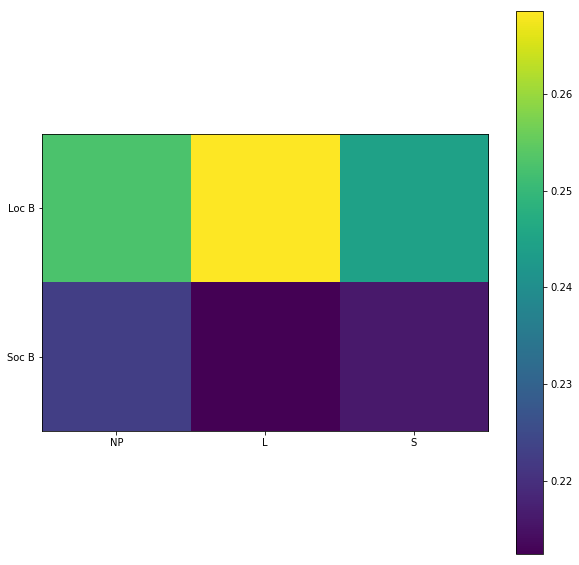

In [98]:
avg_perm = np.mean(all_avg_points, axis = 2)
print(avg_perm)

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_perm)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['Loc B', 'Soc B']
ax.set_yticks([0,1])
ax.set_yticklabels(y_label_list)

## C. Priming effect of matching to Boundaries
### 1. Calculate the priming effect for the actual data

In [99]:
actual_val_pe = avg_points_actual[0,1] - avg_points_actual[0,0] + avg_points_actual[1,2] - avg_points_actual[1, 0]

### 2. Plot a historgram of permuted priming effects and the actual priming effect

The p value is  0.063


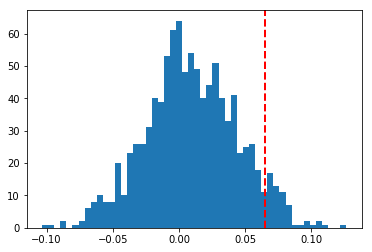

In [106]:
# convert list of PEs to np
PEs = np.asarray(better_primed)
# Plot the histogram
plt.hist(PEs, bins = 50)
# Show the actual data
plt.axvline(x=actual_val_pe, color='r', linestyle='dashed', linewidth=2)
# Calculate the P-value
p_val = ((PEs > actual_val_pe).sum())/1000
print('The p value is ', p_val)

## D. Interaction between priming
### 1. Calculate the interaction for the actual data

In [107]:
actual_val_intrct = avg_points_actual[0,1] - avg_points_actual[0,2] + avg_points_actual[1,2] - avg_points_actual[1, 1]

### 2. Plot a historgram of permuted priming effects and the actual priming effect

The p value is  0.343


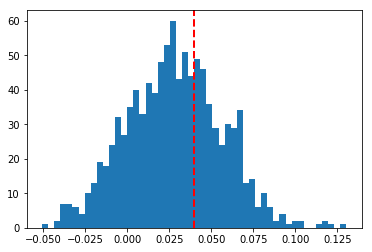

In [109]:
# convert list of PEs to np
Intrcts = np.asarray(priming_interaction)
# Plot the histogram
plt.hist(Intrcts, bins = 50)
# Show the actual data
plt.axvline(x=actual_val_intrct, color='r', linestyle='dashed', linewidth=2)
# Calculate the P-value
p_val = ((Intrcts > actual_val_intrct).sum())/1000
print('The p value is ', p_val)